# 機械学習用日本語テキストデータ
## 機械学習用日本語テキストデータ
どこかにあるのかもしれないが、あまりなさそうなので自分でどうにかしてみる。

既に誰かが着手済みかもしれないが、[景気ウォッチャー調査][1]の「景気判断理由集（現状）」と「景気判断理由集（先行き）」を機械学習で扱いやすいように処理してみる。

## 景気判断理由集について
上記URLを見てもらえば直ぐに分かって頂けるが、
- 「景気判断理由集（現状）」と「景気判断理由集（先行き）」の2種類の情報が共にCSVファイルで提供されている
- 平成25年1月からのデータが毎月提供されている
- 基本は各月現状と先行きの2つのCSVファイルだが、年によっては別掲がある。この場合、現状と先行きの別掲が2つのCSVファイルで提供されている。
    - 基本は現状が*4.csv、先行きが*5.csv
    - 別掲は現状が*6.csv, 先行きが*7.csv
- 「景気判断理由集（現状）」では、以下の4カラムが使える
    - 景気の現状判断	
    - 業種・職種
    - 判断の理由	
    - 追加説明及び具体的状況の説明
- 「景気判断理由集（先行き）」は以下の3カラム
    - 景気の先行き判断	
    - 業種・職種	
    - 景気の先行きに対する判断理由
- 「追加説明及び具体的状況の説明」と「景気の先行きに対する判断理由」が文章になっている。Xとして使える。
- 「景気の現状判断」と「景気の先行き判断」は共に5段階評価となっている。yとして使える。
- また、「現状」の「判断の理由」は「追加説明及び具体的状況の説明」の判断理由(短い文章)となっている。これもyとして使える。
- コードはShift-JISで、フォーマットはCSVだが、「開けた途端に悲しくなるフォーマット」になっている。
- 現状の基本(*4.csv)と別掲(*6.csv)はフォーマットが異なっている。更に、先行きの基本(*5.csv)と別掲(*7.csv)もフォーマットが異なる。別掲はデータ数が少ないので対象外とする。

## 懸念事項
1. 重複と文章の長さ 
判断理由のテキストの数量は平成29年1月調査分で現状、先行き共に1000を越える。しかし、短い文もあり、重複しているかもしれない。  

## ストップワード 
ストップワードは、SlothLibのものを使わせていただいた。
ストップワードは、[SlothLib][2]の[もの][3]を使わせていただいた。  


[1]: http://www5.cao.go.jp/keizai3/watcher_index.html
[2]: http://www.dl.kuis.kyoto-u.ac.jp/slothlib/
[3]: http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

# 初期設定

In [1]:
import pandas as pd
import sys
import CaboCha
import os
import seaborn as sns
from urllib.error import HTTPError
import pickle
import unicodedata
import re

sswords_file = "./stopwords.txt" # from SlothLib
data_dir = "./watchers/"
# log_dir = "./watchers.log/"
pickle_file0 = "./watchers-dfs.pickel"
pickle_file1 = "./watchers.pickel"

cols_for_four=["eval","ind","reasons","txt"]
cols_for_five=cols_for_four[:]
del cols_for_five[2]

# NUM_TO_IGNORE = 1

cols_for_fiveを確認

In [2]:
cols_for_five

['eval', 'ind', 'txt']

In [3]:
def initialize_df():
#     _df4 = pd.DataFrame(index=[], columns=["eval","ind","reasons","txt"])
#     _df5 = pd.DataFrame(index=[], columns=["eval","ind","txt"])
    _df4 = pd.DataFrame(index=[], columns=cols_for_four)
    _df5 = pd.DataFrame(index=[], columns=cols_for_five)
    return _df4, _df5

df4, df5 = initialize_df()

In [4]:
print("{}\n{}".format(df4,df5))

Empty DataFrame
Columns: [eval, ind, reasons, txt]
Index: []
Empty DataFrame
Columns: [eval, ind, txt]
Index: []


# ファイルのダウンロード
一つ下のセルはプログラム作成初期のもの。ファイルを1つだけダウンロード。二つ下のセルは複数ファイルダウンロード版。

In [7]:
# import urllib.request
# urlwatcher="http://www5.cao.go.jp/keizai3/2018/0208watcher/watcher5.csv"
# fneles=urlwatcher.split("/") # file name elements
# fn="./watchers/" + fneles[4] + fneles[5][0:4] + "." +fneles[6]
# urllib.request.urlretrieve(urlwatcher,fn)

In [5]:
# import urllib.request
# # urlwatchers = [ 
# #     "http://www5.cao.go.jp/keizai3/2018/0308watcher/watcher4.csv",
# #     "http://www5.cao.go.jp/keizai3/2018/0308watcher/watcher5.csv"
# #     ]
# urlwatchers = [ # as of 2018/08/23
#     "http://www5.cao.go.jp/keizai3/2018/0208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0308watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0308watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0409watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0409watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0510watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0510watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0608watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0608watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0709watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0709watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0808watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0808watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0308watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0308watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0410watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0410watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0511watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0511watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0608watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0608watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0710watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0710watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0808watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0808watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0908watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0908watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1010watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1010watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1109watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1109watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/1208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0112watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2018/0112watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0308watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0308watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0408watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0408watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0512watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0512watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0608watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0608watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0708watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0708watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0808watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0808watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0908watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0908watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1011watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1011watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1109watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1109watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/1208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0112watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2017/0112watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0209watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0209watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0309watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0309watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0408watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0408watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0513watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0513watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0608watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0608watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0708watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0708watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0810watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0810watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0908watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0908watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1008watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1008watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1110watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1110watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/1208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0112watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2016/0112watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0210watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0210watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0310watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0310watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0408watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0408watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0512watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0512watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0609watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0609watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0708watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0708watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0808watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0808watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0908watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0908watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1008watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1008watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1111watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1111watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/1208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0113watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2015/0113watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0208watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0208watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0308watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0308watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0408watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0408watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0510watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0510watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0610watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0610watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0708watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0708watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0808watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0808watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0909watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/0909watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1008watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1008watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1111watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1111watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1209watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2013/1209watcher/watcher5.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0114watcher/watcher4.csv",
#     "http://www5.cao.go.jp/keizai3/2014/0114watcher/watcher5.csv",
#     ]
# for _u in urlwatchers:
#     try:
#         fneles=_u.split("/") # file name elements
#         fn="./watchers/" + fneles[4] + fneles[5][0:4] + "." +fneles[6]
#         urllib.request.urlretrieve(_u,fn)
#     except HTTPError:
#         print("error occurred when downloading {}".format(_u))

In [9]:
#
# 削除対象
#
# anyfiles = os.listdir(data_dir)
# file_names = [_f for _f in anyfiles if os.path.isfile(os.path.join(data_dir, _f))]
# file_names

ディレクトリー(data_dir)内のファイル情報を取得とする。

In [5]:
def make_input_files(_fn):
    return [data_dir+_f for _f in file_names]
    
# file_names = ["20180208.watcher4.csv", 
#               "20180308.watcher4.csv",
#               "20180208.watcher5.csv", 
#               "20180308.watcher5.csv"]
# file_names = ["20180208.watcher4.csv", "20180308.watcher4.csv"]
# file_names = ["20180208.watcher5.csv", "20180308.watcher5.csv"]
# file_names = ["20180208.watcher4.csv"]
# file_names = ["20180208.watcher5.csv"]

anyfiles = os.listdir(data_dir)
file_names = [_f for _f in anyfiles if os.path.isfile(os.path.join(data_dir, _f))]

input_files = make_input_files(file_names)
input_files

['./watchers/20140512.watcher4.csv',
 './watchers/20180510.watcher4.csv',
 './watchers/20130909.watcher5.csv',
 './watchers/20170908.watcher4.csv',
 './watchers/20151110.watcher4.csv',
 './watchers/20140310.watcher4.csv',
 './watchers/20160908.watcher4.csv',
 './watchers/20130308.watcher4.csv',
 './watchers/20140609.watcher4.csv',
 './watchers/20180409.watcher4.csv',
 './watchers/20160408.watcher5.csv',
 './watchers/20150513.watcher4.csv',
 './watchers/20160112.watcher5.csv',
 './watchers/20170710.watcher4.csv',
 './watchers/20170410.watcher4.csv',
 './watchers/20150810.watcher4.csv',
 './watchers/20150408.watcher5.csv',
 './watchers/20180308.watcher5.csv',
 './watchers/20150908.watcher5.csv',
 './watchers/20171208.watcher4.csv',
 './watchers/20170112.watcher4.csv',
 './watchers/20170808.watcher5.csv',
 './watchers/20180409.watcher5.csv',
 './watchers/20130208.watcher5.csv',
 './watchers/20180510.watcher5.csv',
 './watchers/20140310.watcher5.csv',
 './watchers/20141208.watcher4.csv',
 

In [6]:
print(len(input_files))

132


## データロードと行･列抽出

In [7]:
#
# 削除対象
#
# def load_data(_f):
# #     _df = pd.read_csv(_f,encoding="cp932",header=None)
# #     return _df
#     try:
#         _df = pd.read_csv(_f,encoding="cp932",header=None)
#         return _df
#     except FileNotFoundError:
#         print("file dones not exit {}".format("abc"))
#         sys.exit()


最初に余計な行を削除。次に余計な列を削除する。残った列数に応じ列名を設定した上でDFを作成する。

In [8]:
def select_data_row_col(_df,_to_col):  
    
    # 最初の8行にターゲットとなるデータが無いことを、以下の記号有無で確認
    searchfor = ["◎", "○", "□", "▲", "×"] 
    if _df.iloc[0:8,:].isin(searchfor).values.sum() != 0:
        print("Something wrong. data is in deleted lines")
    
    # 行と列を選択
    _df = _df.iloc[8:,2:2+_to_col]
    
    _colslen = len(_df.columns)
    if _colslen == 4:    _cols = cols_for_four
    elif _colslen == 3:  _cols = cols_for_five
    else:
        print("Something wrong in select_data_row_col() _colslen:{}".format(_colslen))
        print(_df.columns)
        print(_df)
        
    _df = pd.DataFrame(_df.values,columns=_cols)
    
    return _df

# テスト用コード。file_namesの1つ目だけで処理を実行
print("{} will be processed".format(file_names[0]))

_now_future = file_names[0].split(".")[1][-1] # watchers4 or watchers5の4とか5を選択
if   _now_future == "4": _to_col = 4
elif _now_future == "5": _to_col = 3
else: print("error when processing file name. {} ===".format(_now_future))
        
df = pd.read_csv(data_dir+file_names[0],encoding="cp932",header=None)
# from IPython.core.debugger import Pdb; Pdb().set_trace()
df = select_data_row_col(df, _to_col)
df.describe()

20140512.watcher4.csv will be processed


,eval,ind,reasons,txt
count,1335,1335,1335,1345
unique,6,546,17,1290
top,□,商店街（代表者）,販売量の動き,－
freq,489,47,314,29


In [9]:
print("{}\n{}\n{}".format(df.shape,df4.shape,df5.shape))

(1365, 4)
(0, 4)
(0, 3)


ファイルを読み込む。*4.csvはdf4に、*5.csvはdf5に追加していく。

In [10]:
def check_and_load_files(_infile):
#     print("---> {}".format(_infile))
    _now_future = _infile.split("/")[2].split(".")[1][-1] # watchers4 or watchers5の4とか5を選択
    if   _now_future == "4": 
        _cols = cols_for_four
        _to_col = 4
    elif _now_future == "5":
        _cols = cols_for_five
        _to_col = 3
    else: print("error when processing file name. {} ===".format(_now_future))
    
    try:
        _df = pd.read_csv(_infile,encoding="cp932",header=None)
        _df = select_data_row_col(_df, _to_col)
    except FileNotFoundError:
        print("file dones not exit {}".format("abc"))
        sys.exit()
    except UnboundLocalError:
        print("UnboundLocalError when processing {}".format(_infile))

    return _df, _cols

for input_file in input_files:
#     print("===> {}".format(input_file))
    df, cols = check_and_load_files(input_file)
    cols_len = len(cols)
    if cols_len == 4:
        df4 = pd.concat([df4,df], ignore_index=True, sort=False)
    elif cols_len == 3:
        df5 = pd.concat([df5,df], ignore_index=True, sort=False)
    else:
        print("cols length error. {}".format(cols_len))
        

In [11]:
print("{} {} {}".format(df.shape,df4.shape,df5.shape))

(1383, 4) (88978, 4) (100184, 3)


dfとcolsの確認

# データ･クリーニング
## カラムeval

In [12]:
if df4.empty == False: print("{}".format(df4["eval"].unique()))

['◎' '○' '□' '▲' '×' nan '景気の現状判断']


In [13]:
if df5.empty == False: print("{}".format(df5["eval"].unique()))

['◎' '○' '□' '▲' '×' nan '景気の先行き判断']


In [14]:
def clean_eval(_df): # '◎', '○', '□', '▲', '×'以外を除く 
    _df = _df.dropna(subset=['eval'])
    # df = df[~df.isin(['景気の現状判断']).any(axis=1)]
    _df = _df.query('eval == ["◎", "○", "□", "▲", "×"]')
    return _df

df4 = clean_eval(df4)
df5 = clean_eval(df5)

if df4.empty == False: assert len(df4["eval"].unique()) == 5
if df5.empty == False: assert len(df5["eval"].unique()) == 5

In [15]:
if df4.empty == False: print("{}".format(df4["eval"].unique()))

['◎' '○' '□' '▲' '×']


In [16]:
if df5.empty == False: print("{}".format(df5["eval"].unique()))

['◎' '○' '□' '▲' '×']


## カラムind
除くべきは、 － 業種・職種 ＊。ここは地道に。
    

In [17]:
if df4.empty == False: print("{}".format(df4["ind"].unique()))

['観光名所（従業員）' 'その他サービスの動向を把握できる者［フェリー］（従業員）' 'スーパー（店長）' '旅行代理店（従業員）'
 '通信会社（企画担当）' '商店街（代表者）' '一般小売店［酒］（経営者）' 'スーパー（役員）' 'コンビニ（エリア担当）'
 'コンビニ（オーナー）' '衣料品専門店（経営者）' '衣料品専門店（店長）' 'その他専門店［ガソリンスタンド］（経営者）'
 '高級レストラン（経営者）' '高級レストラン（スタッフ）' '観光型ホテル（スタッフ）' 'タクシー運転手' '美容室（経営者）'
 '百貨店（売場主任）' '家電量販店（店員）' '乗用車販売店（従業員）' '乗用車販売店（役員）' '自動車備品販売店（店長）'
 '観光型ホテル（役員）' 'パチンコ店（役員）' '住宅販売会社（役員）' '百貨店（販売促進担当）' '家電量販店（地区統括）'
 'その他専門店［医薬品］（経営者）' '住宅販売会社（経営者）' '－' 'その他サービス業［ソフトウェア開発］（経営者）' '建設業（従業員）'
 '輸送業（営業担当）' '輸送業（支店長）' '通信業（営業担当）' '司法書士' '食料品製造業（経営者）' '家具製造業（経営者）'
 '金融業（企画担当）' 'その他非製造業［鋼材卸売］（役員）' '求人情報誌製作会社（編集者）' '職業安定所（職員）'
 '学校［大学］（就職担当）' '人材派遣会社（社員）' '新聞社［求人広告］（担当者）' 'スーパー（経営者）' 'コンビニ（店長）'
 '家電量販店（従業員）' '住関連専門店（経営者）' 'その他専門店［酒］（経営者）' '一般レストラン（経営者）' '観光型旅館（スタッフ）'
 '観光名所（職員）' '一般小売店［医薬品］（経営者）' '衣料品専門店（総務担当）' '家電量販店（店長）' '自動車備品販売店（経営者）'
 'その他専門店［パソコン］（経営者）' 'その他専門店［靴］（従業員）' 'その他専門店［白衣・ユニフォーム］（営業担当）'
 'その他専門店［ガソリンスタンド］（営業担当）' '観光型ホテル（経営者）' '都市型ホテル（スタッフ）' '通信会社（営業担当）'
 '遊園地（経営者）' 'その他サービス［自動車整備業］（経営者）' '設計事務所（経営

In [18]:
if df5.empty == False: print("{}".format(df5["ind"].unique()))

['＊' '商店街（代表者）' '一般小売店［土産］（経営者）' '百貨店（売場主任）' '百貨店（販売促進担当）' 'スーパー（店長）'
 'スーパー（役員）' 'コンビニ（エリア担当）' '衣料品専門店（店員）' '家電量販店（経営者）' '家電量販店（地区統括部長）'
 '乗用車販売店（従業員）' '乗用車販売店（営業担当）' '観光型ホテル（スタッフ）' '旅行代理店（従業員）' 'タクシー運転手'
 '通信会社（企画担当）' '観光名所（従業員）' '一般小売店［酒］（経営者）' '百貨店（役員）' '衣料品専門店（店長）'
 '家電量販店（店員）' '自動車備品販売店（店長）' 'その他専門店［造花］（店長）' '高級レストラン（経営者）'
 '高級レストラン（スタッフ）' 'スナック（経営者）' '通信会社（社員）' '観光名所（職員）' '美容室（経営者）'
 '住宅販売会社（経営者）' '住宅販売会社（従業員）' 'スーパー（企画担当）' 'その他専門店［医薬品］（経営者）'
 '一般レストラン（スタッフ）' '観光型ホテル（経営者）' 'その他サービスの動向を把握できる者［フェリー］（従業員）' '輸送業（支店長）'
 'その他サービス業［建設機械レンタル］（総務担当）' '建設業（経営者）' '金融業（企画担当）' 'コピーサービス業（従業員）'
 'その他サービス業［建設機械リース］（支店長）' 'その他非製造業［鋼材卸売］（役員）' '食料品製造業（役員）' '家具製造業（経営者）'
 '金属製品製造業（役員）' '通信業（営業担当）' '司法書士' 'その他サービス業［ソフトウェア開発］（経営者）' '建設業（従業員）'
 '輸送業（営業担当）' '－' '求人情報誌製作会社（編集者）' '職業安定所（職員）' '人材派遣会社（社員）'
 '新聞社［求人広告］（担当者）' '学校［大学］（就職担当）' '百貨店（営業担当）' '百貨店（経営者）' 'コンビニ（経営者）'
 '衣料品専門店（経営者）' '家電量販店（店長）' '乗用車販売店（経営者）' '乗用車販売店（店長）' '住関連専門店（経営者）'
 'その他専門店［白衣・ユニフォーム］（営業担当）' '高級レストラン（支配人）' '一般レストラン（経営者）' '都市型ホテル（スタッ

In [19]:
def clean_ind(_df):
    _df = _df.dropna(subset=['ind'])
    _df = _df[~_df.isin(['－','業種・職種','＊']).any(axis=1)] # 業種･職種はeval処理で消えているが念の為。
    return _df

df4 = clean_ind(df4)
df5 = clean_ind(df5)

In [20]:
if df4.empty == False: print("{}".format(df4["ind"].unique()))

['観光名所（従業員）' 'その他サービスの動向を把握できる者［フェリー］（従業員）' 'スーパー（店長）' '旅行代理店（従業員）'
 '通信会社（企画担当）' '商店街（代表者）' '一般小売店［酒］（経営者）' 'スーパー（役員）' 'コンビニ（エリア担当）'
 'コンビニ（オーナー）' '衣料品専門店（経営者）' '衣料品専門店（店長）' 'その他専門店［ガソリンスタンド］（経営者）'
 '高級レストラン（経営者）' '高級レストラン（スタッフ）' '観光型ホテル（スタッフ）' 'タクシー運転手' '美容室（経営者）'
 '百貨店（売場主任）' '家電量販店（店員）' '乗用車販売店（従業員）' '乗用車販売店（役員）' '自動車備品販売店（店長）'
 '観光型ホテル（役員）' 'パチンコ店（役員）' '住宅販売会社（役員）' '百貨店（販売促進担当）' '家電量販店（地区統括）'
 'その他専門店［医薬品］（経営者）' '住宅販売会社（経営者）' 'その他サービス業［ソフトウェア開発］（経営者）' '建設業（従業員）'
 '輸送業（営業担当）' '輸送業（支店長）' '通信業（営業担当）' '司法書士' '食料品製造業（経営者）' '家具製造業（経営者）'
 '金融業（企画担当）' 'その他非製造業［鋼材卸売］（役員）' '求人情報誌製作会社（編集者）' '職業安定所（職員）'
 '学校［大学］（就職担当）' '人材派遣会社（社員）' '新聞社［求人広告］（担当者）' 'スーパー（経営者）' 'コンビニ（店長）'
 '家電量販店（従業員）' '住関連専門店（経営者）' 'その他専門店［酒］（経営者）' '一般レストラン（経営者）' '観光型旅館（スタッフ）'
 '観光名所（職員）' '一般小売店［医薬品］（経営者）' '衣料品専門店（総務担当）' '家電量販店（店長）' '自動車備品販売店（経営者）'
 'その他専門店［パソコン］（経営者）' 'その他専門店［靴］（従業員）' 'その他専門店［白衣・ユニフォーム］（営業担当）'
 'その他専門店［ガソリンスタンド］（営業担当）' '観光型ホテル（経営者）' '都市型ホテル（スタッフ）' '通信会社（営業担当）'
 '遊園地（経営者）' 'その他サービス［自動車整備業］（経営者）' '設計事務所（経営者）' 

In [21]:
if df5.empty == False: print("{}".format(df5["ind"].unique()))

['商店街（代表者）' '一般小売店［土産］（経営者）' '百貨店（売場主任）' '百貨店（販売促進担当）' 'スーパー（店長）'
 'スーパー（役員）' 'コンビニ（エリア担当）' '衣料品専門店（店員）' '家電量販店（経営者）' '家電量販店（地区統括部長）'
 '乗用車販売店（従業員）' '乗用車販売店（営業担当）' '観光型ホテル（スタッフ）' '旅行代理店（従業員）' 'タクシー運転手'
 '通信会社（企画担当）' '観光名所（従業員）' '一般小売店［酒］（経営者）' '百貨店（役員）' '衣料品専門店（店長）'
 '家電量販店（店員）' '自動車備品販売店（店長）' 'その他専門店［造花］（店長）' '高級レストラン（経営者）'
 '高級レストラン（スタッフ）' 'スナック（経営者）' '通信会社（社員）' '観光名所（職員）' '美容室（経営者）'
 '住宅販売会社（経営者）' '住宅販売会社（従業員）' 'スーパー（企画担当）' 'その他専門店［医薬品］（経営者）'
 '一般レストラン（スタッフ）' '観光型ホテル（経営者）' 'その他サービスの動向を把握できる者［フェリー］（従業員）' '輸送業（支店長）'
 'その他サービス業［建設機械レンタル］（総務担当）' '建設業（経営者）' '金融業（企画担当）' 'コピーサービス業（従業員）'
 'その他サービス業［建設機械リース］（支店長）' 'その他非製造業［鋼材卸売］（役員）' '食料品製造業（役員）' '家具製造業（経営者）'
 '金属製品製造業（役員）' '通信業（営業担当）' '司法書士' 'その他サービス業［ソフトウェア開発］（経営者）' '建設業（従業員）'
 '輸送業（営業担当）' '求人情報誌製作会社（編集者）' '職業安定所（職員）' '人材派遣会社（社員）' '新聞社［求人広告］（担当者）'
 '学校［大学］（就職担当）' '百貨店（営業担当）' '百貨店（経営者）' 'コンビニ（経営者）' '衣料品専門店（経営者）'
 '家電量販店（店長）' '乗用車販売店（経営者）' '乗用車販売店（店長）' '住関連専門店（経営者）'
 'その他専門店［白衣・ユニフォーム］（営業担当）' '高級レストラン（支配人）' '一般レストラン（経営者）' '都市型ホテル（スタッフ）'
 '旅行

## カラムreasons
ここも地道に。'判断の理由','－','＊'とnan。ただし、これは4のファイルのみ。

In [22]:
if df4.empty == False: print("{}".format(df4['reasons'].unique()))

['来客数の動き' 'それ以外' '単価の動き' 'お客様の様子' '販売量の動き' '受注量や販売量の動き' '取引先の様子'
 '受注価格や販売価格の動き' '求人数の動き' '採用者数の動き' '雇用形態の様子' '求職者数の動き' '競争相手の様子' '周辺企業の様子']


In [23]:
def clean_reasons(_df):
    _df = _df.dropna(subset=['reasons'])
    _df = _df[~_df.isin(['－','判断の理由','＊']).any(axis=1)] 
    return (_df)

if df4.empty == False: df4 = clean_reasons(df4)



In [24]:
if df4.empty == False: print("{}".format(df4['reasons'].unique()))

['来客数の動き' 'それ以外' '単価の動き' 'お客様の様子' '販売量の動き' '受注量や販売量の動き' '取引先の様子'
 '受注価格や販売価格の動き' '求人数の動き' '採用者数の動き' '雇用形態の様子' '求職者数の動き' '競争相手の様子' '周辺企業の様子']


## カラムtxt
'・'始まりの行は有効。それ以外は無効。

In [25]:
if df4.empty == False: print("{}".format(df4.describe()))

         eval       ind reasons                     txt
count   83660     83660   83660                   83660
unique      5       878      14                   82888
top         □  商店街（代表者）  販売量の動き  ・手持ち工事の繁忙度の高い状態が続いている。
freq    41251      3092   17862                      24


In [26]:
if df5.empty == False: print("{}".format(df5.describe()))

         eval       ind              txt
count   95040     95040            95040
unique      5       909            93766
top         □  商店街（代表者）  ・良くなる要素が見当たらない。
freq    48977      3141               60


"・"始まりのデータを正とする。

In [27]:
def clean_txt(_df):
    _df = _df[_df['txt'].str.startswith('・')]
    return (_df)

# df = clean_txt(df)

df4 = clean_txt(df4)
df5 = clean_txt(df5)

In [28]:
if df4.empty == False: print("{}".format(df4.describe()))

         eval       ind reasons                     txt
count   83580     83580   83580                   83580
unique      5       878      14                   82808
top         □  商店街（代表者）  販売量の動き  ・手持ち工事の繁忙度の高い状態が続いている。
freq    41212      3088   17843                      24


In [29]:
if df5.empty == False: print("{}".format(df5.describe()))

         eval       ind              txt
count   94956     94956            94956
unique      5       909            93682
top         □  商店街（代表者）  ・良くなる要素が見当たらない。
freq    48928      3136               60


In [30]:
if df4.empty != True: print("df4 {}".format(df4.describe().at["freq","txt"]))
if df5.empty != True: print("df5 {}".format(df5.describe().at["freq","txt"]))

df4 24
df5 60


## 重複対応
重複排除する。

In [31]:
print("{} {}".format(sum(df4.duplicated()),sum(df5.duplicated())))

436 779


In [32]:
def delete_dups(_df):
    _df = _df.drop_duplicates()
    return _df

if df4.empty == False: df4 = delete_dups(df4)
if df5.empty == False: df5 = delete_dups(df5)

assert sum(df4.duplicated()) == 0
assert sum(df5.duplicated()) == 0

In [33]:
print("{} {}".format(sum(df4.duplicated()),sum(df5.duplicated())))

0 0


# データ準備
## y_data準備

In [34]:
def make_y(_df):
    _y_data = _df["eval"].replace({'◎': 0, '○': 1, '□':2, '▲':3, '×':4 })
    return _y_data

# y_data = make_y(df)
# assert len(y_data.unique()) == 5

# y_data
if df4.empty == False: y_data_4 = make_y(df4)
if df5.empty == False: y_data_5 = make_y(df5)

if df4.empty == False: assert len(y_data_4.unique()) == 5
if df5.empty == False: assert len(y_data_5.unique()) == 5


## y2_data準備
判断の理由を2つ目のy(y2)とする

In [35]:
# _d = {}
# df4["reasons"].unique()
# for _i in df4["reasons"].unique():
#     print(_i)
# for _n,_i in enumerate(df4["reasons"].unique()):
#     _d[_i]=_n
# _d
_d = {}
def dicappend(_i,_e):
    _d[_e] = _i
[dicappend(_i,_e) for _i,_e in enumerate(df4["reasons"].unique())]
_d

{'来客数の動き': 0,
 'それ以外': 1,
 '単価の動き': 2,
 'お客様の様子': 3,
 '販売量の動き': 4,
 '受注量や販売量の動き': 5,
 '取引先の様子': 6,
 '受注価格や販売価格の動き': 7,
 '求人数の動き': 8,
 '採用者数の動き': 9,
 '雇用形態の様子': 10,
 '求職者数の動き': 11,
 '競争相手の様子': 12,
 '周辺企業の様子': 13}

In [36]:
def make_y2(_df):
    
    # 辞書作成。{'来客数の動き': 0, '販売量の動き': 1}
    _d={}
    for _n,_i in enumerate(df4["reasons"].unique()):
        _d[_i]=_n
        
    # 置換え
    _y2_data = _df["reasons"].replace(_d)
    return _y2_data

# y_data = make_y(df)
# assert len(y_data.unique()) == 5

# y_data
if df4.empty == False: y2_data_4 = make_y2(df4)
# y2_data_4
# if df4.empty == False: assert len(y_data_4.unique()) == 5
# if df5.empty == False: assert len(y_data_5.unique()) == 5


In [37]:
y_data_4.shape

(83144,)

In [38]:
y2_data_4.shape

(83144,)

## X_data準備

In [39]:
def cabop(_cp, _str):
    tree = _cp.parse(_str)
    # print(tree.toString(CaboCha.FORMAT_TREE))
#     print(tree.toString(CaboCha.FORMAT_LATTICE))
    _ctreeFL = tree.toString(CaboCha.FORMAT_LATTICE)
    # type(ctreeFL)
    return _ctreeFL
    # print(tree.toString(CaboCha.FORMAT_TREE_LATTICE))
    

In [40]:
def load_sswords(_f):
    with open(_f,"rt") as _f:
        return [_w.strip() for _w in _f]
        
sswords = load_sswords(sswords_file)
assert len(sswords) > 0
# sswords

In [41]:
def prepare_text_proc():
    _cp = CaboCha.Parser()
    sswords = load_sswords(sswords_file)
    _X_df4 = pd.DataFrame(index=[], columns=["txt"])
    _X_df5 = pd.DataFrame(index=[], columns=["txt"])
    return _X_df4, _X_df5, _cp

X_train_text4, X_train_text5, cp = prepare_text_proc()

In [42]:
def remove_first_char(_str):
    return _str[1:]

# # print("{}".format(remove_first_char("・直接雇用を前提とした紹介予定派遣の問合せが増えている。")))
# base_text = df["txt"].map(remove_first_char).to_frame()
base_text4 = df4["txt"].map(remove_first_char).to_frame()
base_text5 = df5["txt"].map(remove_first_char).to_frame()

assert base_text4.query('txt.str.startswith("･")', engine='python').empty == True
assert base_text5.query('txt.str.startswith("･")', engine='python').empty == True
# if base_text.query('txt.str.startswith("･")', engine='python').empty:
#     print("then")
# else:
#     print("else")

### 分かち書きとストップワード処理  
ストップワードは、[SlothLib][2]の[もの][3]を使わせていただいた。  

[2]: http://www.dl.kuis.kyoto-u.ac.jp/slothlib/
[3]: http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

In [43]:
def separte_line(_block):
    _b = _block.split("\n")
    for _l in _b:
        _l = _l.split("\t")
        if _l == "EOS" or len(_l) == 1:              # EOSの行と係り受け情報の行を無視
            continue
        _analyzed = _l[1].split(',')                 # 形態素の行は解析情報(タブ以降=_l[1]を","で分解 
        if _analyzed[0] == '記号' or len(_l[0]) == 1: # 記号と一文字以下のワードは削除
            continue
#         print("{} {}".format(len(_l),_l[1].split(",")[6])) # 原形を返す。  
        _retstr = _l[1].split(",")[6]                # 原形を返す
        if _retstr == "*":                           # 原形が"*"のケースがあるので対応
            _retstr = _l[0]
        
        _retstr = unicodedata.normalize('NFKC', _retstr)
        _retstr = re.sub(r'[0-9]+月?', "", _retstr)
        if _retstr == "": continue
        
        yield _retstr
    

In [77]:
#
# 適当なタイミングでこのセルは削除する
#
# d = {'txt': ["ここ数か月、来客数の動向が変わらない。","外国人客の訪日が堅調である。また、ＬＣＣの新規就航などで国内客も伸びている。全体的に国内における景気回復の動きが客の地域間移動を底上げしており、当店においてもプラスとなっている。"] }
# df2 = pd.DataFrame(data=d)
# df3 = pd.DataFrame(index=df2.index,columns=["txt"])
# for _index, _row in df2.iterrows():
# #     print("=== {} {}".format(index,row['txt']))
#     waka = [_w for _w in separte_line(cabop(_row["txt"])) if _w not in sswords]
#     df3.iat[_index,0] = " ".join(waka)

In [78]:
# train_text_in_a_df = pd.DataFrame(index=base_text.index,columns=["txt"]) # DataFrame作成
# for _index, _row in base_text.iterrows():           # base_textをインプットにして
# #     print("{} {}".format(index,row['txt']))              # 分かち書きをtrain_text_in_a_dfに
#     waka = [_w for _w in separte_line(cabop(_row["txt"])) if _w not in sswords]
#     train_text_in_a_df.iat[_index,0] = " ".join(waka)

In [79]:
# # for _index, _row in base_text4.iterrows():
# #     print(_index)
# for _index, _row in enumerate(base_text4["txt"]):
#     print("{} {}".format(_index,_row))

In [44]:
def wakachi_gaki(_bt):
    _train_text = pd.DataFrame(index=_bt.index,columns=["txt"]) # DataFrame作成
#     for _index, _row in _bt.iterrows():           # base_textをインプットにして
    for _index, _row in enumerate(_bt["txt"]):                 # base_textをインプットにして
    #     print("{} {}".format(index,row['txt']))              # 分かち書きをtrain_text_in_a_dfに
#         waka = [_w for _w in separte_line(cabop(cp, _row["txt"])) if _w not in sswords]
        waka = [_w for _w in separte_line(cabop(cp, _row)) if _w not in sswords]
        _train_text.iat[_index,0] = " ".join(waka)
    return _train_text

if base_text4.empty == False: X_train_text4 = wakachi_gaki(base_text4)
if base_text5.empty == False: X_train_text5 = wakachi_gaki(base_text5)

In [ ]:
#  if X_train_text4.empty == False: print("{}".format(X_train_text4))

In [82]:
# if X_train_text5.empty == False: print("{}".format(X_train_text5))

In [45]:
print("{} {}".format(X_train_text4.shape[0],X_train_text5.shape[0]))
print("{} {}".format(y_data_4.shape[0],y_data_5.shape[0]))
print("{}".format(y2_data_4.shape[0]))

83144 94177
83144 94177
83144


## データの保存
2018年8月実行時点でpickleファイルは32MB。

In [46]:
with open(pickle_file1, 'wb') as f:
    pickle.dump(X_train_text4, f)
    pickle.dump(y_data_4, f)
    pickle.dump(y2_data_4, f)
    pickle.dump(X_train_text5, f)
    pickle.dump(y_data_5, f)

## データの長さ

In [49]:
def get_length(_str):
    return len( _str.split() )
len4 = X_train_text4["txt"].map(get_length).to_frame()
len5 = X_train_text5["txt"].map(get_length).to_frame()
# print(len4,len5)

In [50]:
print("{} {}".format(X_train_text4.shape[0],X_train_text5.shape[0]))
print("{} {}".format(y_data_4.shape[0],y_data_5.shape[0]))
print("{}".format(y2_data_4.shape[0]))

83144 94177
83144 94177
83144


In [87]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.hist(len4)

In [51]:
print(len4.shape,len5.shape)

(83144, 1) (94177, 1)


In [52]:
TH_NUM = 0 # thresh hold number
print(sum(len4["txt"]>0),sum(len5["txt"]>0))

83144 94177


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb4f6a91d0>]],
      dtype=object)

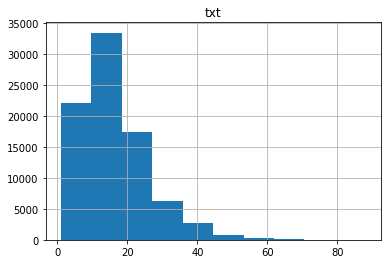

In [53]:
len4.hist("txt")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb41092518>]],
      dtype=object)

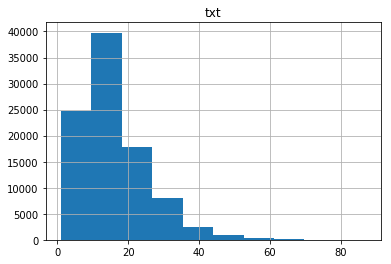

In [54]:
len5.hist("txt")

In [55]:
# sns.distplot(len4, kde=False, rug=False, bins=10) 
# sns.distplot(len4, kde=False, rug=False, bins=10)

In [56]:
len4.describe()

,txt
count,83144.000000
mean,16.299504
std,9.567171
min,1.000000
25%,9.000000
50%,14.000000
75%,21.000000
max,88.000000


In [57]:
len5.describe()

,txt
count,94177.000000
mean,16.013517
std,9.197724
min,1.000000
25%,9.000000
50%,14.000000
75%,21.000000
max,87.000000
